# 1. 文本表示：从one-hot到word2vec

文本表示分为离散表示和分布式表示

## 1.1 词袋模型：离散、高维、稀疏

词袋模型：
BoW(Bag-of-words) 是n-gram语法模型的特例1元模型。该模型忽略掉文本的语法和语序等要素，将其仅仅看作是若干个词汇的集合，文档中每个单词的出现都是独立的。BoW使用一组无序的单词(words)来表达一段文字或一个文档。

第一种形式：One-Hot Encoding，只要在词典中出现的词，无论出现多少次，在BOW向量中都只算成1次，未出现的词算0次,然后根据词典构造只有0/1的向量。

特点：只强调了出现词与未出现词的差异(在有些短文本分类中可能会表现很好)，对于出现词之间的差异未体现。

第二种形式：词频向量 TF，只要在词典中出现的词，出现多少次就算成多少次，未出现的词算0次，然后根据词典构造向量。

可能会出现的问题：长文本比短文本对每个单词有更高的出现次数，尽管他们可能在描述同一个主题，用单词计数会有偏差。

第三种形式：TF-IDF，各文档中每个单词的出现次数除以该文档中所有单词的总数，也可以对词频进行归一化来降低这种影响。

如果文档很多，整个文集中不同单词的数量非常大，而单个文档使用的单词数量远远少于总体词袋单词个数。tf-idf向量维度会非常大而且每个向量中大多数的值为 0 。此时词袋模型得到的向量是 高维稀疏数据。



## 1.2 分布式表示：连续、低维、稠密。word2vec词向量原理并实践，用来表示文本

分布式表示：word2vec 和 glove

word2vec：Skip-gram 和 CBOW 模型

    如果是用一个词语作为输入，来预测它周围的上下文，那这个模型叫做『Skip-gram 模型』
    而如果是拿一个词语的上下文作为输入，来预测这个词语本身，则是 『CBOW 模型』

CBOW 是 Continuous Bag-of-Words 的缩写，与神经网络语言模型不同的是，CBOW去掉了最耗时的非线性隐藏层。
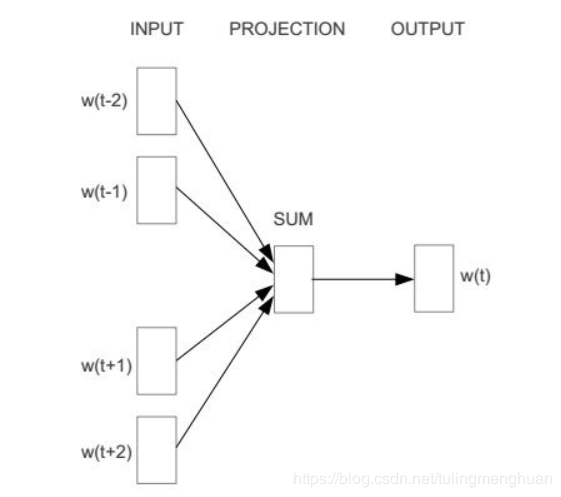
从图中可以看出，CBOW模型预测的是 p(wt∣wt−2,wt−1,wt+1,wt+2)，由于图中目标词 wt 前后只取了各两个词，所以窗口的总大小是2。假设目标词 w_t 前后各取k个词，即窗口的大小是k，那么CBOW模型预测的将是p(wt∣wt−k,wt−(k−1),⋅⋅⋅,wt−1,wt+1,⋅⋅⋅,wt+(k−1),wt+k)。

输入层到隐藏层

以上图为例，输入层是四个词的one-hot向量表示，分别为 xt−2,xt−1,xt+1,xt+2维度都为V x 1，V是模型的训练本文中所有词的个数），记输入层到隐藏层的权重矩阵为 W （维度为V x d，d是认为给定的词向量维度），隐藏层的向量为 h （维度为d x 1），那么

h=(WT⋅xt−2+WT⋅xt−1+WT⋅xt+1+WT⋅xt+2)/4其实这里就是一个简单地求和平均。

隐藏层到输出层

记隐藏层到输出层的权重矩阵为 U （维度为d x V），输出层的向量为 y （维度为V x 1），那么

y=softmax(UT⋅h)

注意，输出层的向量 y 与输入层的向量为 x_{ * } 虽然维度是一样的，但是 y 并不是one-hot向量，并且向量 y 中的每个元素都是有意义的。例如，我们假设训练样本只有一句话“I like to eat apple”，此刻我们正在使用 I、like、eat、apple 四个词来预测 to ，输出层的结果如下图所示。
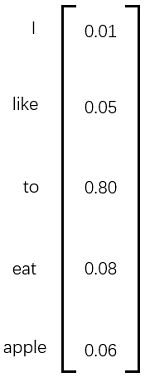

向量y中的每个元素表示我用 I、like、eat、apple 四个词预测出来的词是当元素对应的词的概率，比如是like的概率为0.05，是to的概率是0.80。由于我们想让模型预测出来的词是to，那么我们就要尽量让to的概率尽可能的大，所以我们目标是最大化函数 L

L=∏Vt=1p(wt∣wt−k,wt−(k−1),⋅⋅⋅,wt−1,wt+1,⋅⋅⋅,wt+(k−1),wt+k)

有了最大化的目标函数，我们接下来要做的就是求解这个目标函数，首先求 -log(L) ，然后求梯度，再梯度下降，具体细节在此省略，因为这种方法涉及到softmax层，softmax每次计算都要遍历整个词表，代价十分昂贵，所以实现的时候我们不用这种方法，而是用层次softmax和负采样。


Skip-Gram的模型图与CBOW恰好相反，如下图所示。
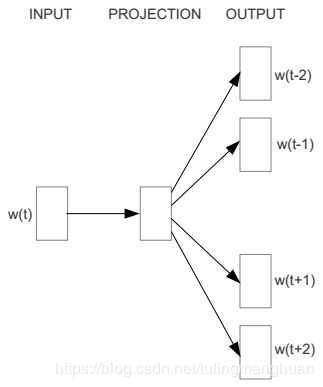
从图中可以看出，Skip-Gram模型预测的是p(wt−2∣wt),p(wt−1∣wt),p(wt+1∣wt),p(wt+2∣wt)，由于图中词 w_t 前后只取了各两个词，所以窗口的总大小是2。假设词 w_t 前后各取k个词，即窗口的大小是k，那么Skip-Gram模型预测的将是 p(wt+p∣wt)(−k≤p≤k,k≠0).

输入层到隐藏层
输入层是词的one-hot向量表示，分别为 x_t （维度都为V x 1，V是模型的训练本文中所有词的个数），记输入层到隐藏层的权重矩阵为 W （维度为V x d，d是认为给定的词向量维度），隐藏层的向量为 h （维度为d x 1），那么


隐藏层到输出层
记隐藏层到输出层的权重矩阵为 U （维度为d x V），输出层的向量为 y （维度为V x 1），那么

y=softmax(UTh)
注意，输出层的向量 y 与输入层的向量为 x_{t} 虽然维度是一样的，但是 y 并不是one-hot向量，并且向量 y 中的每个元素都是有意义的。具体的例子见CBOW中的图3，Skip-Gram里我们目标是最大化函数 L

L=∏Vt=1∏kp=−k,t≠0p(wt+p∣wt)

层次softmax和负采样
softmax层非常昂贵，每次计算的复杂度为 O(V) ，所以我们用层次softmax或者负采样来替换掉输出层，降低复杂度。

层次softmax
首先，层次softmax是一棵huffman树，树的叶子节点是训练文本中所有的词，非叶子节点都是一个逻辑回归二分类器，每个逻辑回归分类器的参数都不同，分别用 θ∗表示。假定分类器的输入是向量 h ，记逻辑回归分类器输出的结果 σ(θ∗h)，将向量 h 传递给节点的左孩子的概率为σ(θ∗h)，否则传递给节点的右孩子的概率是 1−σ(θ∗h) 。重复这个传递的流程直到叶子节点。
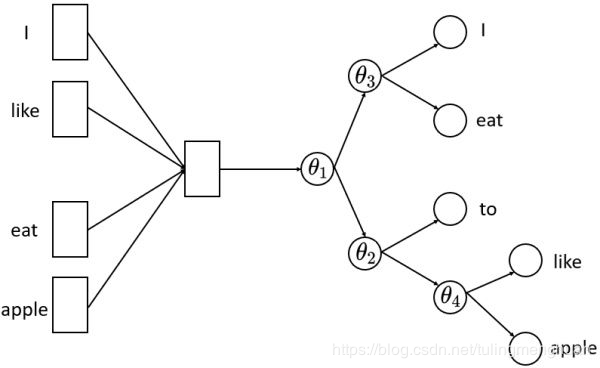
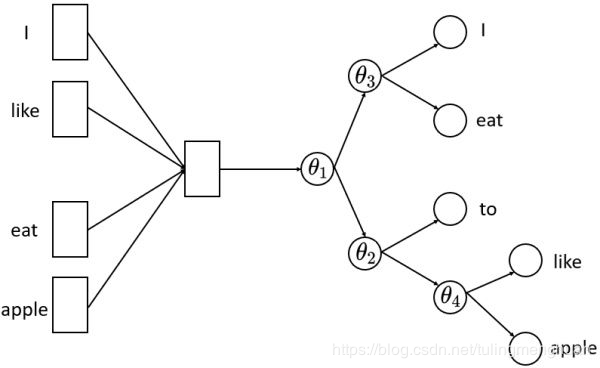
将隐藏层的向量 h 直接传给了一个层次softmax，层次softmax的复杂度为 O(log(V)) 。层次softmax采样到每个词的概率分别如下：

采样到 I 的概率 p(I∣context)=(1−σ(θ1h))∗(1−σ(θ3h)

采样到 eat 的概率 p(eat∣context)=(1−σ(θ1h))∗σ(θ3h)

采样到 to 的概率 p(to∣context)=σ(θ1h)∗(1−σ(θ2h))

采样到 like 的概率 p(like∣context)=σ(θ1h)∗σ(θ2h)∗(1−σ(θ4h)

采样到 apple 的概率 p(apple∣context)=σ(θ1h)∗σ(θ2h)∗σ(θ4h) 

果我们要预测的词是 to ，那么我们就要让 p(to|context) 尽量大一点，所以现在我们的任务转化为了训练 V-1 个逻辑回归分类器。CBOW模型和Skip-Gram模型训练的目标函数与之前形式一样，为LCBOW=∏Vt=1p(wt∣wt−k,wt−(k−1),⋅⋅⋅,wt−1,wt+1,⋅⋅⋅,wt+(k−1),wt+k) 

LSkip_Gram=∏Vt=1∏kp=−k,t≠0p(wt+p∣wt)

负采样
负采样实际上是采样负例来帮助训练的手段，其目的与层次softmax一样，是用来提升模型的训练速度。我们知道，模型对正例的预测概率是越大越好，模型对负例的预测概率是越小越好。由于正例的数量少，很容易保证每个正例的预测概率尽可能大，而负例的数量特别多，所以负采样的思路就是根据某种负采样的策略随机挑选一些负例，然后保证挑选的这部分负例的预测概率尽可能小。所以，负采样策略是对模型的效果影响很大，word2vec常用的负采样策略有均匀负采样、按词频率采样等等。
CBOW

以“I like to eat apple”为例子，假设窗口的大小是2，即我们会用 I to 来预测 like，所以在这里我们就认为（I，like）和（to，like）都是正例，而（I，apple）、（to，apple）就是负例，因为（I，apple）、（to，apple）不会出现在正例中。那么，对于给定的正样本（Context(w)，w）和采样出的负样本（NEG(w)，w），有

p(w∣Context(w))=σ(θwhContext(w))
这里的 θw是词w的向量表示， h 表示隐藏层的输出向量
我们需要最大化的目标函数为

LCBOW=∏Vt=1p(wt∣Context(wt))⋅p(wt∣NEG(wt))

简单来说，上述目标函数的含义就是让正例的概率更大，负例的概率更小

Skip-Gram

以“I like to eat apple”为例子，假设窗口的大小是2，即我们会用 like 来预测 I to，所以在这里我们就认为（like，I）和（like，to）都是正例，而（like，apple）就是负例，因为（like，apple）不会出现在正例中。那么，对于给定的正样本（w，context(w)）和采样出的负样本（w，NEG(w)），有

p(Context(w)∣w)=∏u∈Context(w)σ(θwhu)

p(NEG(w)∣w)=∏u∈NEG(w)(1−σ(θwhu))

我们需要最大化的目标函数为

LSkip_Gram=∏Vt=1p(Context(wt)∣wt)⋅p(NEG(wt)∣wt)


实践

关于word2vec模型的介绍见这篇。我们使用gensim中的word2vec API来训练模型。

官方API介绍如下：

class gensim.models.word2vec.Word2Vec(sentences=None, corpus_file=None, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, iter=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), max_final_vocab=None)


主要参数介绍如下：
1) sentences：我们要分析的语料，可以是一个列表，或者从文件中遍历读出（word2vec.LineSentence(filename) ）。

2) size：词向量的维度，默认值是100。这个维度的取值一般与我们的语料的大小相关，如果是不大的语料，比如小于100M的文本语料，则使用默认值一般就可以了。如果是超大的语料，建议增大维度。

3) window：即词向量上下文最大距离，window越大，则和某一词较远的词也会产生上下文关系。默认值为5，在实际使用中，可以根据实际的需求来动态调整这个window的大小。

   如果是小语料则这个值可以设的更小。对于一般的语料这个值推荐在[5；10]之间。

4) sg：即我们的word2vec两个模型的选择了。如果是0， 则是CBOW模型；是1则是Skip-Gram模型；默认是0即CBOW模型。

5) hs：即我们的word2vec两个解法的选择了。如果是0， 则是Negative Sampling；是1的话并且负采样个数negative大于0， 则是Hierarchical Softmax。默认是0即Negative Sampling。

6) negative：即使用Negative Sampling时负采样的个数，默认是5。推荐在[3,10]之间。这个参数在我们的算法原理篇中标记为neg。

7) cbow_mean：仅用于CBOW在做投影的时候，为0，则算法中的xw为上下文的词向量之和，为1则为上下文的词向量的平均值。在我们的原理篇中，是按照词向量的平均值来描述的。个人比较喜欢用平均值来表示xw,默认值也是1,不推荐修改默认值。

8) min_count：需要计算词向量的最小词频。这个值可以去掉一些很生僻的低频词，默认是5。如果是小语料，可以调低这个值。

9) iter：随机梯度下降法中迭代的最大次数，默认是5。对于大语料，可以增大这个值。

10) alpha：在随机梯度下降法中迭代的初始步长。算法原理篇中标记为η，默认是0.025。

11) min_alpha: 由于算法支持在迭代的过程中逐渐减小步长，min_alpha给出了最小的迭代步。


In [ ]:
import logging
import gensim
from gensim.models import word2vec

# 设置输出日志
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 直接用gemsim提供的API去读取txt文件，读取文件的API有LineSentence 和 Text8Corpus, PathLineSentences等。
sentences = word2vec.LineSentence("/data4T/share/jiangxinyang848/textClassifier/data/preProcess/wordEmbdiing.txt")

# 训练模型，词向量的长度设置为200， 迭代次数为8，采用skip-gram模型，模型保存为bin格式
model = gensim.models.Word2Vec(sentences, size=200, sg=1, iter=8)  
model.wv.save_word2vec_format("./word2Vec" + ".bin", binary=True) 

# 加载bin格式的模型
wordVec = gensim.models.KeyedVectors.load_word2vec_format("word2Vec.bin", binary=True)

参考：https://blog.csdn.net/tulingmenghuan/article/details/89467012